<a href="https://colab.research.google.com/github/SukritTM/CEHC-internship/blob/main/Covid_pathology_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/radiodata.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [ ]:
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import cv2

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import activations

In [ ]:
os.rename('COVID-19_Radiography_Dataset', 'dataset')

In [ ]:
os.listdir('dataset/COVID/masks')

True

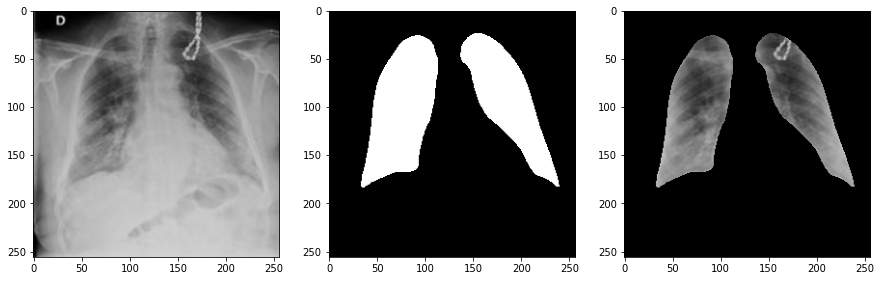

In [ ]:
image = cv2.resize(cv2.imread('dataset/COVID/images/COVID-868.png'), (256,256))
mask = cv2.imread('dataset/COVID/masks/COVID-868.png')
figure, axis = plt.subplots(1,3, figsize=(15,15))
axis[0].imshow(image)
axis[1].imshow(mask)
axis[2].imshow(-image*mask)
cv2.imwrite('testimage.png', mask)

In [ ]:
def prepdata(path, dest):
  for filename in os.listdir(os.path.join(path, 'images')):
    image = cv2.resize(cv2.imread(os.path.join(path, 'images', filename)), (256,256))
    mask = cv2.resize(cv2.imread(os.path.join(path, 'masks', filename)), (256,256))
    masked = -image*mask
    
    head, tail = os.path.split(path.strip('/'))
    cv2.imwrite(os.path.join(dest, tail, filename), masked)

In [ ]:
os.mkdir('data')
os.mkdir('data/COVID')
os.mkdir('data/Normal')

In [ ]:
prepdata('dataset/COVID', 'data')
prepdata('dataset/Normal', 'data')

In [ ]:
def loaddata(path):
  tlist = list()
  for filename in os.listdir(path):
    image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
    tlist.append(tf.expand_dims(tf.convert_to_tensor(image), 2))
  
  return tf.stack(tlist)

In [ ]:
cov_t = loaddata('data/COVID')
nor_t = loaddata('data/Normal')

In [ ]:
class_names = {'COVID': 0, 'Normal': 1}

In [ ]:
cov_d = tf.data.Dataset.from_tensor_slices((cov_t, tf.zeros(len(cov_t), dtype=tf.dtypes.int32))).repeat(3)
nor_d = tf.data.Dataset.from_tensor_slices((nor_t, tf.ones(len(nor_t), dtype=tf.dtypes.int32)))

In [ ]:
print(cov_d.cardinality().numpy())
print(nor_d.cardinality().numpy())

10848
10192


In [ ]:
cov_d = cov_d.shuffle(20000, seed=32)
nor_d = nor_d.shuffle(20000, seed=32)

In [ ]:
newds = tf.data.Dataset.sample_from_datasets([cov_d, nor_d], weights=[0.5, 0.5], seed=32).shuffle(20000)

In [ ]:
newds = newds.batch(batch_size=128).shuffle(20000, seed=32)

In [ ]:
ds_size = len(list(newds.as_numpy_iterator()))
train_ds = newds.take(int(0.8*ds_size))
val_ds = newds.skip(int(0.8*ds_size)).take(int(0.1*ds_size))
test_ds = newds.skip(int(0.8*ds_size)).skip(int(0.1*ds_size))

In [ ]:
img_batch, label_batch = next(iter(train_ds))
print(label_batch[1])

tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
for lab in label_batch:
  if lab.numpy() == 1:
    print('found')
    break
print('end')

end


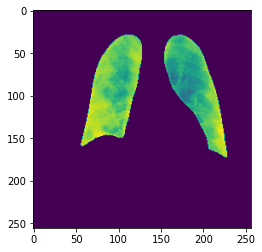

In [ ]:
plt.imshow(img_batch[1].numpy()[:,:,0])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
gapmodel = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(256, 256, 1), name='c1'),
    layers.Conv2D(64, (3,3), activation=tf.nn.relu, name='c2'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3,3), activation=tf.nn.relu),
    layers.Conv2D(32, (3,3), activation=tf.nn.relu),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3,3), activation=tf.nn.relu),
    layers.Conv2D(2, (3,3), activation=tf.nn.relu),
    
    layers.GlobalAveragePooling2D(),

    layers.Softmax()


])
gapmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1 (Conv2D)                 (None, 254, 254, 64)      640       
                                                                 
 c2 (Conv2D)                 (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 32)      18464     
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                        

In [ ]:
gapmodel.compile(loss=losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs=150
history = gapmodel.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/150
132/132 [==============================] - 56s 419ms/step - loss: 0.7095 - accuracy: 0.5123 - val_loss: 0.6531 - val_accuracy: 0.5171
Epoch 2/150
132/132 [==============================] - 55s 419ms/step - loss: 0.6396 - accuracy: 0.5151 - val_loss: 0.6126 - val_accuracy: 0.5171
Epoch 3/150
132/132 [==============================] - 55s 419ms/step - loss: 0.6179 - accuracy: 0.5157 - val_loss: 0.5971 - val_accuracy: 0.5171
Epoch 4/150
132/132 [==============================] - 55s 419ms/step - loss: 0.6143 - accuracy: 0.5352 - val_loss: 0.5934 - val_accuracy: 0.6816
Epoch 5/150
132/132 [==============================] - 55s 419ms/step - loss: 0.5787 - accuracy: 0.7009 - val_loss: 0.5148 - val_accuracy: 0.7588
Epoch 6/150
132/132 [==============================] - 55s 418ms/step - loss: 0.5145 - accuracy: 0.7488 - val_loss: 0.4747 - val_accuracy: 0.7695
Epoch 7/150
132/132 [==============================] - 55s 418ms/step - loss: 0.4918 - accuracy: 0.7637 - val_loss: 0.4710 -

In [ ]:
gapmodel.evaluate(train_ds)

132/132 [==============================] - 16s 118ms/step - loss: 0.6896 - accuracy: 0.5147


[0.6895699501037598, 0.5146883726119995]

In [ ]:
gapmodel.evaluate(test_ds)

17/17 [==============================] - 3s 119ms/step - loss: 0.6903 - accuracy: 0.5106


[0.6903311014175415, 0.5105698704719543]

In [ ]:
gapmodel.evaluate(test_ds)

17/17 [==============================] - 3s 119ms/step - loss: 0.0786 - accuracy: 0.9701


[0.078622967004776, 0.9701286554336548]

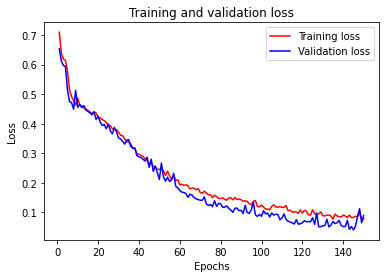

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

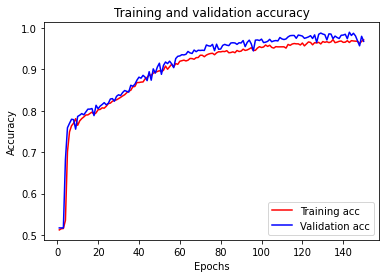

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
gapmodel.save('gapmodelb_150')

In [ ]:
!zip -r 'gapmodelb_150.zip' 'gapmodelb_150'

  adding: gapmodelb_150/ (stored 0%)
  adding: gapmodelb_150/assets/ (stored 0%)
  adding: gapmodelb_150/saved_model.pb (deflated 89%)
  adding: gapmodelb_150/keras_metadata.pb (deflated 92%)
  adding: gapmodelb_150/variables/ (stored 0%)
  adding: gapmodelb_150/variables/variables.index (deflated 70%)
  adding: gapmodelb_150/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
from google.colab import files
files.download('gapmodelb_150.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation=tf.nn.relu, input_shape=(256, 256, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    layers.Flatten(),

    layers.Dense(32, activation=tf.nn.relu),
    layers.Dropout(0.2),

    layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 62, 62, 64)       

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
epochs=100
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/100
132/132 [==============================] - 24s 174ms/step - loss: 3.3228 - binary_accuracy: 0.6690 - val_loss: 0.4681 - val_binary_accuracy: 0.7930
Epoch 2/100
132/132 [==============================] - 23s 172ms/step - loss: 0.4278 - binary_accuracy: 0.7959 - val_loss: 0.3021 - val_binary_accuracy: 0.8828
Epoch 3/100
132/132 [==============================] - 23s 172ms/step - loss: 0.3094 - binary_accuracy: 0.8588 - val_loss: 0.2021 - val_binary_accuracy: 0.9175
Epoch 4/100
132/132 [==============================] - 23s 171ms/step - loss: 0.2312 - binary_accuracy: 0.8937 - val_loss: 0.1536 - val_binary_accuracy: 0.9409
Epoch 5/100
132/132 [==============================] - 23s 171ms/step - loss: 0.1883 - binary_accuracy: 0.9160 - val_loss: 0.1389 - val_binary_accuracy: 0.9512
Epoch 6/100
132/132 [==============================] - 23s 171ms/step - loss: 0.1553 - binary_accuracy: 0.9288 - val_loss: 0.1283 - val_binary_accuracy: 0.9556
Epoch 7/100
132/132 [===================

In [ ]:
model.evaluate(train_ds)

132/132 [==============================] - 8s 55ms/step - loss: 0.0041 - binary_accuracy: 0.9989


[0.0040606246329844, 0.9989296197891235]

In [ ]:
model.evaluate(test_ds)

17/17 [==============================] - 1s 57ms/step - loss: 0.1148 - binary_accuracy: 0.9862


[0.11476477980613708, 0.986213207244873]

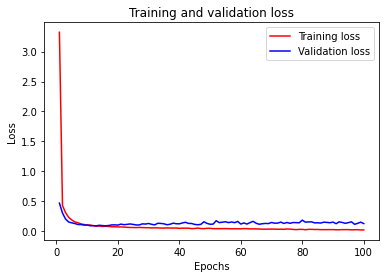

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

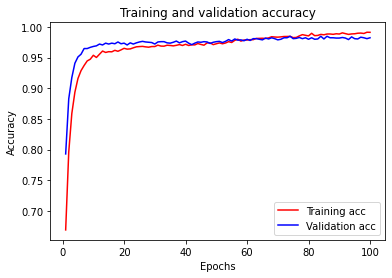

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model.save('modelb_150')

INFO:tensorflow:Assets written to: modelb_150/assets


In [ ]:
!zip -r 'modelb_150.zip' 'modelb_150'

  adding: modelb_150/ (stored 0%)
  adding: modelb_150/saved_model.pb (deflated 89%)
  adding: modelb_150/variables/ (stored 0%)
  adding: modelb_150/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: modelb_150/variables/variables.index (deflated 65%)
  adding: modelb_150/keras_metadata.pb (deflated 90%)
  adding: modelb_150/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download('modelb_150.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>